In [73]:
import kaggle
import pandas as pd
import zipfile
import os
import logging
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

### Import da Data Base

In [74]:
# Autenticação (irá utilizar o arquivo kaggle.json configurado)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Nome da competição
competition_name = 'home-credit-default-risk'

# Diretório para salvar os dados
data_dir = './home_credit_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Baixar os dados da competição
print('Baixando os dados...')
api.competition_download_files(competition_name, path=data_dir)

# Descompactar o arquivo
zip_path = os.path.join(data_dir, f'{competition_name}.zip')
print('Descompactando os arquivos...')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Remover o arquivo zip após a extração
os.remove(zip_path)

print('Arquivos descompactados.')

# Carregar o arquivo de treino em um DataFrame do Pandas
train_df_path = os.path.join(data_dir, 'application_train.csv')
df = pd.read_csv(train_df_path)

# Visualizar as primeiras linhas do DataFrame
print(df.head())

Baixando os dados...
Descompactando os arquivos...
Arquivos descompactados.
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_

In [75]:
logging.info("Combinando os dataframes de treino e teste...")

teste_df_path = os.path.join(data_dir, 'application_test.csv')

# Acessa os dataframes de treino e teste a partir do dicionário
df_train = pd.read_csv(train_df_path)
df_test = pd.read_csv(teste_df_path)

# Guarda o número de linhas do treino para poder separar depois
train_rows = len(df_train)

# Guarda os IDs do conjunto de teste para a submissão final
test_ids = df_test['SK_ID_CURR']

# A coluna 'TARGET' só existe no treino. O Pandas irá preencher com NaN no teste.
target = df_train['TARGET']

# Remove a coluna TARGET do treino para que as colunas fiquem alinhadas
df_train = df_train.drop(columns=['TARGET'])

In [76]:

# Concatena os dois dataframes
df_full = pd.concat([df_train, df_test], ignore_index=True)

logging.info("Merge concluído!")

print("\n" + "="*50)
print("      DATAFRAME COMBINADO CRIADO: 'df_full'")
print("="*50)
print(f"Shape do df_train original: {df_train.shape}")
print(f"Shape do df_test original:  {df_test.shape}")
print(f"Shape do df_full combinado: {df_full.shape}")
print("\n'df_full' está pronto para o pré-processamento unificado.")


      DATAFRAME COMBINADO CRIADO: 'df_full'
Shape do df_train original: (307511, 121)
Shape do df_test original:  (48744, 121)
Shape do df_full combinado: (356255, 121)

'df_full' está pronto para o pré-processamento unificado.


In [77]:
pd.set_option('display.max_columns', None)

### 1. Limpeza  dos Dados

#### 1.1 Inconsistentes

In [78]:
df_full.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,121014.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356253.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,162345.000000,3.555870e+05,286622.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,185200.000000,355205.000000,355205.000000,355205.000000,355205.000000,356254.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.00000,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,-4983.593527,-3002.071163,12.023741,0.999994,0.818498,0.200098,0.998170,0.278612,0.071213,2.151858,2.050506,2.028932,12.055749,0.015649,0.051371,0.040847,0.078076,0.229661,0.178824,0.501965,5.148900e-01,0.509350,0.118138,0.088673,0.977889,0.752283,0.045045,0.079819,0.150015,0.227331,0.232817,0.066454,0.101495,0.108089,0.008868,0.028503,0.114914,0.087750,0.977239,0.759452,0.042930,0.075346,0.145471,0.223315,0.228878,0.065092,0.106382,0.106641,0.008116,0.027183,0.118549,0.088178,0.977903,0.755548,0.

In [79]:
print("Estatísticas de 'DAYS_EMPLOYED' antes da correção:")
print(df_full['DAYS_EMPLOYED'].describe())

Estatísticas de 'DAYS_EMPLOYED' antes da correção:
count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


In [80]:
df_full['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

C:\Users\MASTER\AppData\Local\Temp\ipykernel_12904\3057025278.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


#### 1.2 Ausentes

In [81]:

porcentagem_nulos = (df_full.isnull().sum() / len(df_full)) * 100

# Filtra para ver apenas as colunas com nulos e ordena para ver as piores
print(porcentagem_nulos[porcentagem_nulos > 0].sort_values(ascending=False))

COMMONAREA_MODE                 69.714109
COMMONAREA_MEDI                 69.714109
COMMONAREA_AVG                  69.714109
NONLIVINGAPARTMENTS_AVG         69.293343
NONLIVINGAPARTMENTS_MODE        69.293343
NONLIVINGAPARTMENTS_MEDI        69.293343
FONDKAPREMONT_MODE              68.235393
LIVINGAPARTMENTS_MODE           68.203674
LIVINGAPARTMENTS_AVG            68.203674
LIVINGAPARTMENTS_MEDI           68.203674
FLOORSMIN_MEDI                  67.678489
FLOORSMIN_AVG                   67.678489
FLOORSMIN_MODE                  67.678489
YEARS_BUILD_MEDI                66.330578
YEARS_BUILD_MODE                66.330578
YEARS_BUILD_AVG                 66.330578
OWN_CAR_AGE                     66.031635
LANDAREA_MEDI                   59.183450
LANDAREA_AVG                    59.183450
LANDAREA_MODE                   59.183450
BASEMENTAREA_MODE               58.268375
BASEMENTAREA_AVG                58.268375
BASEMENTAREA_MEDI               58.268375
NONLIVINGAREA_MEDI              54

In [82]:
tabela_cruzada = pd.crosstab(df_full['FLAG_OWN_CAR'], df_full['OWN_CAR_AGE'].isnull())

print("Relação entre possuir carro e ter a idade do carro nula:")
print(tabela_cruzada)

Relação entre possuir carro e ter a idade do carro nula:
OWN_CAR_AGE    False   True 
FLAG_OWN_CAR                
N                  0  235235
Y             121014       6


In [83]:
# TRATAMENTO ESPECIAL PARA OWN_CAR_AGE
# Com base na nossa análise, preenchemos os nulos de OWN_CAR_AGE com 0.
print("\nAplicando imputação inteligente em 'OWN_CAR_AGE'...")
df_full.fillna({'OWN_CAR_AGE': 0}, inplace=True)
print("'OWN_CAR_AGE' foi tratada e não será removida.")


#REMOVER COLUNAS COM NULOS ACIMA DE 50%
print("\nIdentificando outras colunas para remover...")
porcentagem_nulos = (df_full.isnull().sum() / len(df_full)) * 100

# Novo limiar ajustado para 50%
limiar_remocao = 50.0

# Identifica as colunas que excedem o limiar
colunas_para_remover = porcentagem_nulos[porcentagem_nulos > limiar_remocao].index.tolist()

print(f"Encontradas {len(colunas_para_remover)} colunas com mais de {limiar_remocao}% de valores nulos.")
print("Elas serão removidas:")
print(colunas_para_remover)

# Re-identifica as colunas restantes
colunas_numericas = df_full.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas = df_full.select_dtypes(include='object').columns.tolist()

# Imputação para colunas numéricas
imputer_numerico = SimpleImputer(strategy='median')
df_full[colunas_numericas] = imputer_numerico.fit_transform(df_full[colunas_numericas])

# Imputação para colunas categóricas
imputer_categorico = SimpleImputer(strategy='most_frequent')
df_full[colunas_categoricas] = imputer_categorico.fit_transform(df_full[colunas_categoricas])

print("\nVerificação final de valores nulos:", df_full.isnull().sum().sum())



Aplicando imputação inteligente em 'OWN_CAR_AGE'...
'OWN_CAR_AGE' foi tratada e não será removida.

Identificando outras colunas para remover...
Encontradas 36 colunas com mais de 50.0% de valores nulos.
Elas serão removidas:
['EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE']

Verificação final de valores nulos: 0


#### 1.3 Redundancia

In [84]:
# Supondo que 'df_full' é o seu dataframe após a imputação de valores
print("--- Verificando Objetos Redundantes (Linhas Duplicadas) ---")

# Conta o número de linhas duplicadas
num_duplicatas = df_full.duplicated().sum()

if num_duplicatas > 0:
    print(f"Foram encontradas {num_duplicatas} linhas duplicadas. Removendo...")
    df_full.drop_duplicates(inplace=True)
else:
    print("Nenhuma linha duplicada foi encontrada. ✅")

--- Verificando Objetos Redundantes (Linhas Duplicadas) ---
Nenhuma linha duplicada foi encontrada. ✅


In [85]:
print("\n--- Análise de Outliers na coluna AMT_INCOME_TOTAL ---")

# Calcula Q1, Q3 e IQR
Q1 = df_full['AMT_INCOME_TOTAL'].quantile(0.05)
Q3 = df_full['AMT_INCOME_TOTAL'].quantile(0.95)
IQR = Q3 - Q1

# Define os limites para detecção de outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Limite inferior para outliers: {limite_inferior:.2f}")
print(f"Limite superior para outliers: {limite_superior:.2f}")

# Conta o número de outliers
num_outliers = ((df_full['AMT_INCOME_TOTAL'] < limite_inferior) | (df_full['AMT_INCOME_TOTAL'] > limite_superior)).sum()
porcentagem_outliers = (num_outliers / len(df_full)) * 100

print(f"\nNúmero de outliers encontrados em AMT_INCOME_TOTAL: {num_outliers} ({porcentagem_outliers:.2f}%)")
print("Para problemas de risco/fraude, outliers podem ser os casos mais importantes, então geralmente não os removemos, mas é crucial saber que eles existem.")


--- Análise de Outliers na coluna AMT_INCOME_TOTAL ---
Limite inferior para outliers: -337500.00
Limite superior para outliers: 742500.00

Número de outliers encontrados em AMT_INCOME_TOTAL: 751 (0.21%)
Para problemas de risco/fraude, outliers podem ser os casos mais importantes, então geralmente não os removemos, mas é crucial saber que eles existem.


Tamanho original: 356255 | Sem outliers: 355504 | Removidos: 751 (0.21%)


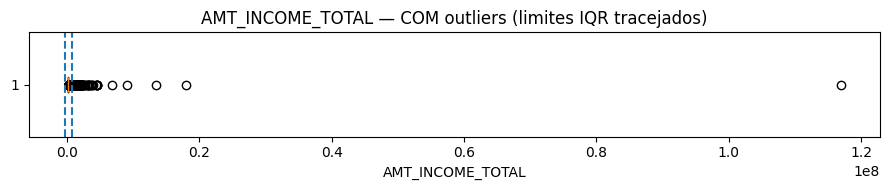

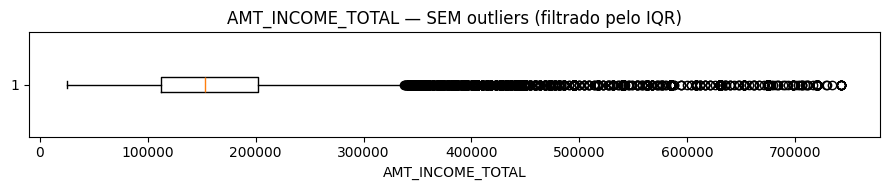

In [86]:
# Série alvo (garante ausência de NaN)
serie = df_full['AMT_INCOME_TOTAL'].dropna()

# Máscara para remover outliers via IQR (usando limites que você já calculou)
mask_sem_outliers = (serie >= limite_inferior) & (serie <= limite_superior)
serie_sem_out = serie[mask_sem_outliers]

# Info rápida
removidos = len(serie) - len(serie_sem_out)
print(f"Tamanho original: {len(serie)} | Sem outliers: {len(serie_sem_out)} | Removidos: {removidos} ({removidos/len(serie)*100:.2f}%)")

# --- 1) COM OUTLIERS (toda a série) ---
plt.figure(figsize=(9, 2))
plt.boxplot(serie, vert=False, showfliers=True)  # inclui pontos outliers
plt.axvline(limite_inferior, linestyle='--')
plt.axvline(limite_superior, linestyle='--')
plt.title('AMT_INCOME_TOTAL — COM outliers (limites IQR tracejados)')
plt.xlabel('AMT_INCOME_TOTAL')
plt.tight_layout()
plt.show()

# --- 2) SEM OUTLIERS (filtrado pelo IQR) ---
plt.figure(figsize=(9, 2))
plt.boxplot(serie_sem_out, vert=False, showfliers=True)  # a série já está sem outliers
plt.title('AMT_INCOME_TOTAL — SEM outliers (filtrado pelo IQR)')
plt.xlabel('AMT_INCOME_TOTAL')
plt.tight_layout()
plt.show()

#### Redução de dimensionalidade

##### Acho que n é agora isso mas ja ta meio pronto

In [ ]:
print("\n--- Redução de Dimensionalidade com PCA ---")

# Para o PCA funcionar, precisamos que todos os dados sejam numéricos.
# Vamos primeiro fazer o One-Hot Encoding (adiantando um passo da Parte II, pois é necessário para o PCA)
# E depois separar o dataframe para aplicar a padronização e o PCA.

# Etapa A: One-Hot Encoding (necessário para o PCA)
df_pca = pd.get_dummies(df_full, dummy_na=False)

# Etapa B: Separar IDs e Padronizar os dados
ids = df_pca['SK_ID_CURR']
df_pca = df_pca.drop(columns=['SK_ID_CURR'])
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(df_pca)

print(f"Número de features antes do PCA: {dados_padronizados.shape[1]}")

# Etapa C: Aplicar o PCA
# Vamos configurar o PCA para reter 95% da variância dos dados.
pca = PCA(n_components=0.95)
dados_pca = pca.fit_transform(dados_padronizados)

print(f"Número de features após o PCA (retendo 95% da variância): {dados_pca.shape[1]}")
print(f"Conseguimos reduzir a dimensionalidade em {dados_padronizados.shape[1] - dados_pca.shape[1]} features. ✅")

# O resultado 'dados_pca' é um array NumPy com as novas features (componentes principais).
# Ele pode ser usado diretamente para treinar modelos.